# Analyze Heavy Correlations

This jupyter notebook analyzes one-time correlations calculated from the heavy trajectories of ReadRun.py

We use the algorithm for Volterra Equations of the second kind, suggested in the Numerical Recipes, Chapter 18.2  
```http://www.aip.de/groups/soe/local/numres/bookcpdf/c18-2.pdf```


Observables are:
- Self-intermediate scattering function
- Mean-square displacement
- Force-force correlations
- Velocity-velocity correlations
- Force-velocity correlations

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import sys
import os
sys.executable
from __future__ import print_function
import numpy as np
import hoomd
from hoomd import md
import gsd.pygsd
import gsd.hoomd
import lib.module_measurements as med
import lib.module_potentials as pot
from gsd import fl
from freud.box import Box
from matplotlib import pyplot as plt
from scipy.stats import sem
import copy
import time


## Import data

Parameters

In [22]:
start_time=time.time()

T=0.6
Natoms=1080
maindir='../../OUTPUT/T'+str(T)+'/N'+str(Natoms)+'/'
if T==10.0:
    samples=[0,1,2,3,4,5,6,7,8,9]
#     isoft=int(NcorrFine*0.02)
elif T==2.0:
    samples=[1,2,3,4,5,6,7,8,9]
#     isoft=int(NcorrFine*0.2)
elif T==0.6:
    samples=[0]
#     isoft=int(NcorrFine*0.3)
else:
    raise ValueError('Please do floating point comparisons properly')
# print('isoft =',isoft)
nsamples=len(samples)
doCd=False

EPS=1e-8

print('Block time: ',time.time()-start_time,"seconds")

Block time:  0.0003612041473388672 seconds


Read L and dt, and verify that they are consistent

In [23]:
start_time=time.time()

for isam in range(nsamples):
    sam=samples[isam]
    name=maindir+'/S'+str(sam)+'/heavyTraj/L.txt'
    f=open(name,'rt')
    if 0==isam:
        L=np.float64(f.readline())
        dt=np.float64(f.readline())
    else:
        Ltemp=np.float64(f.readline())
        dttemp=np.float64(f.readline())
        if np.abs(L - Ltemp)>EPS: raise ValueError('isam %d has an incompatible L  (%.9g) with sample 0 (%.9g)'%(isam, Ltemp, L))
        if np.abs(dt-dttemp)>EPS: raise ValueError('isam %d has an incompatible dt (%.9g) with sample 0 (%.9g)'%(isam,dttemp,dt))
    f.close()
    
#Cleanup
if nsamples>1: del Ltemp, dttemp
    
print('Block time: ',time.time()-start_time,"seconds")

Block time:  0.022583723068237305 seconds


Read positions, velocities and accelerations of all samples

In [24]:
start_time=time.time()

all_times=[]
all_pos=[]
all_vel=[]
all_acc=[]
ntimes=np.zeros(nsamples,dtype=int)
for isam in range(nsamples):
    sam=samples[isam]
    sampledir=maindir+'/S'+str(sam)+'/heavyTraj/'
    #Read list of times
    timesName=sampledir+'times.txt'
    timelist=np.loadtxt(timesName)
    ntimes[isam]=len(timelist)
    print('There are ',ntimes[isam],' configurations in total')

    
    #Read accelerations
    pos = []
    vel = []
    acc = []
    fpos=open(sampledir+'/pos.npy','rb')
    fvel=open(sampledir+'/vel.npy','rb')
    facc=open(sampledir+'/acc.npy','rb')
        
    for i in range(ntimes[isam]):
        pos.append(np.load(fpos))
        vel.append(np.load(fvel))
        acc.append(np.load(facc))
    fpos.close()
    fvel.close()
    facc.close()

    
    #Relevant quantities
    if 0==isam:
        Natoms=len(pos[0])
    elif Natoms!=len(pos[0]): 
        raise ValueError('isam %d has an inconsistent Natoms=%d, inconsistent with sample 0 that has %d'%(isam,len(pos[0]),Natoms))
    initialPositions=pos[0]
    all_times.append(timelist)
    all_pos.append(pos)
    all_vel.append(vel)
    all_acc.append(acc)

del pos,vel,acc,timelist
    
all_pos=np.array(all_pos)
all_vel=np.array(all_vel)
all_acc=np.array(all_acc)

print('Block time: ',time.time()-start_time,"seconds")

There are  28124  configurations in total
Block time:  19.80234932899475 seconds


Waiting times

In [25]:
start_time=time.time()

#number of trajectory starting times for each sample
ntw=np.zeros(nsamples,dtype=np.int)
twlist=[]
for isam in range(nsamples):
    twlist.append(np.unique(all_times[isam][:,0]))
    ntw[isam]=len(twlist[isam])   
print("ntw: ",ntw)

print('Block time: ',time.time()-start_time,"seconds")

ntw:  [575]
Block time:  0.001146078109741211 seconds


Sort Observables

In [26]:
start_time=time.time()

nt=np.zeros(nsamples,dtype=np.int)
tlist  =[]
poslist=[]
vellist=[]
acclist=[]
print(np.shape(all_pos))
for isam in range(nsamples):    
    tlist_sam  =[]
    poslist_sam=[]
    vellist_sam=[]
    acclist_sam=[]
    nt[isam]=0
    for itw in range(ntw[isam]):
        tw=twlist[isam][itw]
        this_tw=np.where(all_times[isam][:,0]==tw)
        first=this_tw[0][0]
        last=this_tw[0][-1]+1
        if last-first>nt[isam]:
            nt[isam]=last-first
            tlist_sam=np.array(all_times[isam][first:last][:,1]-all_times[isam][first][1], dtype=np.int64)
        poslist_sam.append(all_pos[isam][first:last])
        vellist_sam.append(all_vel[isam][first:last])
        acclist_sam.append(all_acc[isam][first:last])
    
    #Remove incomplete entries
    for itw in np.arange(ntw[isam]-1,-1,-1):
        if len(poslist_sam[itw]) != nt[isam]:
            assert(len(vellist_sam[itw]) == len(poslist_sam[itw]))
            assert(len(acclist_sam[itw]) == len(poslist_sam[itw]))
            del poslist_sam[itw]
            del vellist_sam[itw]
            del acclist_sam[itw]
            twlist[isam]=np.delete(twlist[isam],itw)

    #poslist, vellist and acclist have the shape: [itw, it, particle, component]

    print('ntw:',ntw[isam],end='  ')
    ntw[isam]=len(twlist[isam])
    print('ntw:',ntw[isam])

    tlist.append(tlist_sam)
    poslist.append(poslist_sam)
    vellist.append(vellist_sam)
    acclist.append(acclist_sam)
del poslist_sam,vellist_sam,acclist_sam,tlist_sam

#The following objects should be of size [nsamples, ntw, nt, Natoms, Dim]
print('ntw must be the same for all samples: ',ntw)
print('nt  must be the same for all samples: ',nt)
print(np.shape(poslist))
print(np.shape(vellist))
print(np.shape(acclist))

print('Block time: ',time.time()-start_time,"seconds")

(1, 28124, 1080, 3)
ntw: 575  ntw: 573
ntw must be the same for all samples:  [573]
nt  must be the same for all samples:  [49]
(1, 573, 49, 1080, 3)
(1, 573, 49, 1080, 3)
(1, 573, 49, 1080, 3)
Block time:  0.57527756690979 seconds


## Calculate observables

In [27]:
start_time=time.time()

hoomd.context.initialize('--mode=cpu');

#READ THERMALIZED SYSTEM (for copying particle types and creating snapshots) AND POTENTIAL
sam=0
system = hoomd.init.read_gsd(filename=maindir+'/S'+str(sam)+'/thermalized.gsd')
assert(np.abs(L-system.box.Lx)<EPS)
pair=pot.LJ(md.nlist.cell(), type='KAshort')
snapA=system.take_snapshot()
snapB=system.take_snapshot()

print('Block time: ',time.time()-start_time,"seconds")

notice(2): Group "all" created containing 1080 particles
Block time:  0.021213293075561523 seconds


In [28]:
start_time=time.time()

#Wave vector for the self-intermediate scattring function
# k =[2 pi/L](n1,n2,n3) and permutations
n1=1; n2=3; n3=4

msd = np.zeros((nsamples, max(ntw), max(nt)), dtype=np.float64)
Fk  = np.zeros((nsamples, max(ntw), max(nt)), dtype=np.float64)
CPP = np.zeros((nsamples, max(ntw), max(nt)), dtype=np.float64)
CFP = np.zeros((nsamples, max(ntw), max(nt)), dtype=np.float64)
CFF = np.zeros((nsamples, max(ntw), max(nt)), dtype=np.float64)
# Cd  = np.zeros((nsamples, max(ntw), max(nt)), dtype=np.float64)
obs=[{} for isam in range(nsamples+1)]
for isam in range(nsamples):
    for itw in range(ntw[isam]):
        initialPositions[:]=poslist[isam][itw][0][:]
        snapA.particles.position[:] = initialPositions[:]
        for iframe in range(0, nt[isam]):
#             print('\risam: %d, itw: %d, it: %d, Cd= %g'%(isam,itw,iframe,Cd[isam][itw][iframe]))
            snapB.particles.position[:] = poslist[isam][itw][iframe][:]
            if doCd: Cd[isam][itw][iframe]=pair.Cd_fast(snapA=snapA,snapB=snapB,beta=1./T)            
            msd[isam][itw][iframe] = med.PeriodicSquareDistance(poslist[isam][itw][iframe], initialPositions, L)/Natoms
            all_displacements= med.PeriodicDisplacement(poslist[isam][itw][iframe], initialPositions, L)
            Fk[isam][itw][iframe]  = med.ComputeFkt(n1, n2, n3, L, all_displacements)

        CPP[isam][itw]=np.array([np.mean([np.inner(vellist[isam][itw][0][atom],vellist[isam][itw][time][atom]) for atom in range(Natoms)]) for time in range(nt[isam])])/3.
        CFP[isam][itw]=np.array([np.mean([np.inner(acclist[isam][itw][0][atom],vellist[isam][itw][time][atom]) for atom in range(Natoms)]) for time in range(nt[isam])])/3.
        CFF[isam][itw]=np.array([np.mean([np.inner(acclist[isam][itw][0][atom],acclist[isam][itw][time][atom]) for atom in range(Natoms)]) for time in range(nt[isam])])/3.

    obs[isam]={
        'msd':{'mean': np.mean(msd[isam],axis=0), 'err': sem(msd[isam], axis=0)},
        'Fk' :{'mean': np.mean(Fk [isam],axis=0), 'err': sem(Fk [isam], axis=0)},
        'CPP':{'mean': np.mean(CPP[isam],axis=0), 'err': sem(CPP[isam], axis=0)},
        'CFP':{'mean': np.mean(CFP[isam],axis=0), 'err': sem(CFP[isam], axis=0)},
        'CFF':{'mean': np.mean(CFF[isam],axis=0), 'err': sem(CFF[isam], axis=0)},
    }
    if doCd: 
        obs[isam]['Cd']={'mean': np.mean(Cd [isam],axis=0), 'err': sem(Cd [isam], axis=0)},

print('Block time: ',time.time()-start_time,"seconds")

Block time:  327.95208621025085 seconds


In [29]:
start_time=time.time()

#Obs is an nsamples-long list. Append to it the average over the samples
obs[nsamples]={
        'msd':{'mean': np.mean(msd,axis=(0,1)), 'err': sem(np.mean(msd, axis=0), axis=0)},
        'Fk' :{'mean': np.mean(Fk ,axis=(0,1)), 'err': sem(np.mean(Fk,  axis=0), axis=0)},
        'CPP':{'mean': np.mean(CPP,axis=(0,1)), 'err': sem(np.mean(CPP, axis=0), axis=0)},
        'CFP':{'mean': np.mean(CFP,axis=(0,1)), 'err': sem(np.mean(CFP, axis=0), axis=0)},
        'CFF':{'mean': np.mean(CFF,axis=(0,1)), 'err': sem(np.mean(CFF, axis=0), axis=0)},
    }
if doCd: 
    obs[nsamples]['Cd']={'mean': np.mean(Cd ,axis=(0,1)), 'err': sem(np.mean(Cd , axis=0), axis=0)},

x=tlist[0]*dt
print('Block time: ',time.time()-start_time,"seconds")

Block time:  0.002679109573364258 seconds


## Plot

### Mean Square Displacement

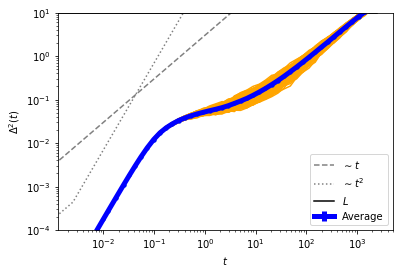

In [30]:
fig=plt.figure(figsize=None)
ax=fig.add_subplot(1,1,1)
ax.set_xscale('log', nonposx='clip')
ax.set_yscale('log', nonposy='clip')
plt.plot(x,3*x,label='$\sim t$',linestyle='--',color='gray')
plt.plot(x,70*np.square(x),label='$\sim t^2$',linestyle=':',color='gray')
plt.plot(x,L*np.ones(len(x)),label='$L$',color='black')
plt.ylabel('$\Delta^2(t)$')
plt.xlabel('$t$')
plt.ylim((1e-4,10))
for isam in range(nsamples):
    plt.errorbar(x,obs[isam]['msd']['mean'],yerr=obs[isam]['msd']['err'],marker='.')
    for itw in range(ntw[isam]):
        plt.plot(x,msd[isam][itw], color='orange')
plt.errorbar(x,obs[nsamples]['msd']['mean'],yerr=obs[nsamples]['msd']['err'],label='Average', marker='.',linewidth=5, color='blue')

plt.legend()
plt.show()



### Self-intermediate scattering function

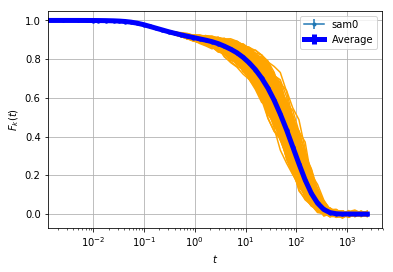

In [31]:
fig=plt.figure(figsize=None)
ax=fig.add_subplot(1,1,1)
ax.set_xscale('log', nonposx='clip')
plt.ylabel('$\Delta^2(t)$')
plt.xlabel('$t$')
for isam in range(nsamples):
    for itw in range(0,ntw[isam]):
        plt.plot(x,Fk[isam][itw], color='orange')
    plt.errorbar(x,obs[isam]['Fk']['mean'],yerr=obs[isam]['Fk']['err'],label='sam'+str(samples[isam]),marker='.')
    #Highlight the first and the last tw, to show that there is no drift
#     plt.plot(x,Fk[isam][0], color='red',label=r'first $t_w$')
#     plt.plot(x,Fk[isam][ntw[isam]-1], color='darkred', label='last $t_w$')
plt.errorbar(x,obs[nsamples]['Fk']['mean'],yerr=obs[nsamples]['Fk']['err'],label='Average',marker='.',linewidth=5, color='blue')


plt.legend()
plt.ylabel('$F_k(t)$')
plt.xlabel('$t$')
plt.grid()
plt.show()



### Momentum-momentum correlation function

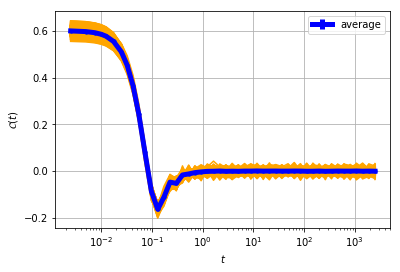

In [32]:
fig=plt.figure(figsize=None)
ax=fig.add_subplot(1,1,1)
ax.set_xscale('log', nonposx='mask')

for isam in range(nsamples):
    plt.errorbar(x,obs[isam]['CPP']['mean'],yerr=obs[isam]['CPP']['err'],marker='.')
    for itw in range(ntw[isam]):
        plt.plot(x,CPP[isam][itw], color='orange')
plt.errorbar(x,obs[nsamples]['CPP']['mean'],yerr=obs[nsamples]['CPP']['err'],marker='.',label='average', linewidth=5, color='blue')
plt.legend()
plt.ylabel('$\mathcal{C}(t)$')
plt.xlabel('$t$')
plt.grid()
plt.show()

### Force-momentum correlation function

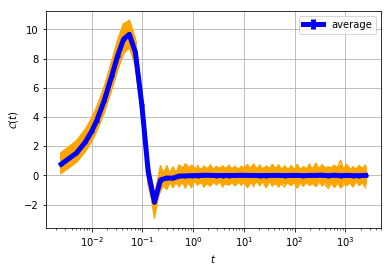

In [33]:
fig=plt.figure(figsize=None)
ax=fig.add_subplot(1,1,1)
ax.set_xscale('log', nonposx='mask')
for isam in range(nsamples):
    plt.errorbar(x,obs[isam]['CFP']['mean'],yerr=obs[isam]['CFP']['err'],marker='.')
    for itw in range(ntw[isam]):
        plt.plot(x,CFP[isam][itw], color='orange')
plt.errorbar(x,obs[nsamples]['CFP']['mean'],yerr=obs[nsamples]['CFP']['err'],marker='.',label='average', linewidth=5, color='blue')
plt.legend()
plt.ylabel('$\mathcal{C}(t)$')
plt.xlabel('$t$')
plt.grid()
plt.show()

### Force-force correlation function

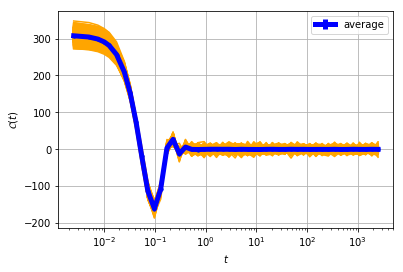

In [34]:
fig=plt.figure(figsize=None)
ax = fig.add_subplot(1, 1, 1)
ax.set_xscale("log", nonposx='mask')
for isam in range(nsamples):    
    plt.errorbar(x,obs[isam]['CFF']['mean'], yerr=obs[isam]['CFF']['err'],marker='.')
    for itw in range(ntw[isam]):
        plt.plot(x,CFF[isam][itw], color='orange')
plt.errorbar(x,obs[nsamples]['CFF']['mean'], yerr=obs[nsamples]['CFF']['err'],marker='.',label='average', linewidth=5, color='blue')

plt.legend()
plt.ylabel('$\mathcal{C}(t)$')
plt.xlabel('$t$')
plt.grid()
plt.show()


# Noise correlation functions

### Integration with linear grid (though the data are logarithmic)

Initialization

In [111]:
start_time=time.time()

from scipy.interpolate import interp1d

start_time=time.time()
#The linear grid
dtfine=0.0025
xmax=x[-1]
reduce=10
xdatafine=np.arange(0, xmax/reduce, dtfine)
NcorrFine=len(xdatafine)
assert(dtfine==xdatafine[1]-xdatafine[0])
print('NcorrFine = ',NcorrFine)
print('xmax =',xmax)
print('xmax effettivo =',xmax/reduce)

#The noise correlation function
f=np.zeros(NcorrFine)

#The data
invT=np.float64(1./T)
dtinvT=dtfine*invT
interpCFF=interp1d(x, obs[nsamples]['CFF']['mean'], kind='cubic')
interpCFP=interp1d(x, obs[nsamples]['CFP']['mean'], kind='cubic')
CFP=interpCFP(xdatafine)-obs[nsamples]['CFP']['mean'][0]
CFF=interpCFF(xdatafine)

#Softening
soften=False
if soften:
    isoft=int(NcorrFine*.1)
    print('isoft = ',isoft)
    CFP[isoft:]*=[np.exp(-i/100) for i in range(0,NcorrFine-isoft)]
    CFF[isoft:]*=[np.exp(-i/100) for i in range(0,NcorrFine-isoft)]

g=np.copy(interpCFF(xdatafine))

print('Block time: ',time.time()-start_time,"seconds")



NcorrFine =  100000
xmax = 2499.9975
xmax effettivo = 249.99975
Block time:  0.021780014038085938 seconds


Interpolation

In [131]:
start_time=time.time()

def trapeze(i,istar=None):
    temp=0.5*CFP[i]*f[0]
    i_ini=0 if istar==None else max(0,i-istar)
    for j in range(i_ini, i-1):
        temp+=CFP[i-j]*f[j]
    return g[i]+dtinvT*temp

f[0]=g[0]
istar=600 #for i>istar the kernels have no signal
print('istar = ',istar,";  xdatafine[istar] =",xdatafine[istar])
for i in range(1,NcorrFine):
    f[i]=trapeze(i,istar)
    
print('Block time: ',time.time()-start_time,"seconds")

istar =  600 ;  xdatafine[istar] = 1.5
Block time:  19.307383060455322 seconds


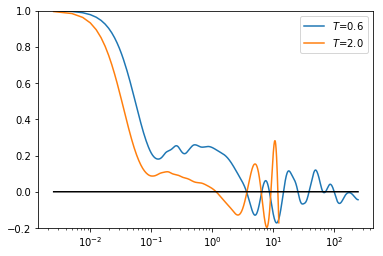

In [135]:
fig=plt.figure(figsize=None)
ax = fig.add_subplot(1, 1, 1)
ax.set_xscale("log", nonposx='mask')
plt.ylim((-.2,1))
plt.plot(xdatafine,f/f[0], label='$T$=%g'%T)
plt.plot(xdatafineT2,fT2/fT2[0], label='$T$=2.0')
plt.plot(xdatafine,np.zeros(len(xdatafine)), color='black')
plt.legend()
plt.show()


In [ ]:
fT2=np.copy(f)
xdatafineT2=np.copy(xdatafine)